## baseline fit and covariance estimation

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from multiprocessing import Pool
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook, trange

import scripts.plot_tools as pt
import scripts.fit_helpers as fh

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 54443,
  "iopub_port": 51587,
  "stdin_port": 48051,
  "control_port": 33827,
  "hb_port": 35695,
  "ip": "127.0.0.1",
  "key": "46dd7772-0aa876e3a88c8798f6df77ff",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-8fa9563a-302a-4403-8a24-871e1bd00f69.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
    'ee', 
    'mumu',  
    'emu', 
    #'etau', 
    #'mutau',
    #'e4j',
    #'mu4j',
             ]
plot_labels = fh.fancy_labels

# initialize fit data
input_dir  = f'local_data/templates/test/'
fit_data = fh.FitData(input_dir, selections, processes, 
                      param_file = 'data/model_parameters_default.csv',
                      use_prefit = False,
                      process_cut = 0.05
                     )

In [3]:
# prepare Asimov dataset
parameters = fit_data._parameters
params_pre = parameters['val_init'].values
asimov_data = {cat:fit_data.mixture_model(parameters.val_init.values, cat) for cat in fit_data._model_data.keys()}

In [4]:
# initialize veto list
fit_data.veto_list = [
    # baseline
    #'ee_cat_gt2_eq1_b', 'ee_cat_gt2_gt2_b', 
    #'mumu_cat_gt2_eq1_b', 'mumu_cat_gt2_gt2_b', 
    #'emu_cat_gt2_eq1_a', 'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    #'e4j_cat_gt4_eq1', 'e4j_cat_gt4_gt2',
    #'mu4j_cat_gt4_eq1', 'mu4j_cat_gt4_gt2', 
    'e4j_cat_eq3_gt2', 'mu4j_cat_eq3_gt2',
    
    # e/mu DY CR
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', 'emu_cat_eq1_eq1_a', 
    
    # e+mu WW
    'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
]

In [5]:
# fit configuration #
scenario = 'asimov'

# minimizer options
min_options = dict(#eps=1e-9, 
                   gtol = 1e-3,
                   disp = True
                  )

# configure the objective
#fit_data._pmask[4:] = False
mask = fit_data._pmask.copy()
if scenario == 'unblinded':
    sample = None
else:
    sample = asimov_data
    
fobj = partial(fit_data.objective,
               data = sample,
               do_bb_lite = True,
               no_shape = False,
               lu_test = 0
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   do_bb_lite = True,
                   no_shape = False,
                   lu_test = 0
                  )


In [6]:
# carry out fit for null hypothesis
result_null = minimize(fobj, params_pre[mask],
                       jac = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )

print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
 null :  0 3.383320290595293e-10 [10.8 10.8 10.8 67.6]


In [7]:
# carry out fit for null hypothesis
#result_null = minimize(fobj, params_pre[mask],
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = {'verbose': 2, 'gtol':1.},
#                       args = ()
#                      )
#
#print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

In [8]:
# carry out fit for alt 1
fobj.keywords['lu_test'] = 1
fobj_jac.keywords['lu_test'] = 1
result_alt1 = minimize(fobj, params_pre[mask],
                       jac     = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )
        
print(' alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
 alt. 1:  0 3.383320290595293e-10 [10.8 10.8 10.8 67.6]


In [9]:
# carry out fit for alt hypothesis
#fobj.keywords['lu_test'] = 1
#fobj_jac.keywords['lu_test'] = 1
#pinit = result_null.x.copy()
#result_alt1 = minimize(fobj, pinit,
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = {'verbose': 2, 'gtol':0.1},
#                       args = ()
#                      )
#
#print('alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

In [10]:
# carry out fit for alt 2
fobj.keywords['lu_test'] = 2
fobj_jac.keywords['lu_test'] = 2
result_alt2 =  minimize(fobj, params_pre[mask],
                        jac     = fobj_jac,
                        method  = 'BFGS', 
                        options = min_options,
                        #bounds  = bnds,
                       )

print(' alt. 2: ', result_alt2.status, result_alt2.fun, result_alt2.x[:4]*100)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
 alt. 2:  0 3.383320290595293e-10 [10.8 10.8 10.8 67.6]


In [11]:
# Wilk's theorem
from scipy.stats import chi2, norm
q1 = 2*(result_null.fun - result_alt1.fun)
z1 = -norm.ppf(chi2.sf(q1, 1))

q2 = 2*(result_null.fun - result_alt2.fun)
z2 = -norm.ppf(chi2.sf(q2, 2))

print(f' test hypothesis 1: q = {q1:.1f}, z = {z1:.1f}')
print(f' test hypothesis 2: q = {q2:.1f}, z = {z2:.1f}')

 test hypothesis 1: q = 0.0, z = -inf
 test hypothesis 2: q = 0.0, z = -inf


In [12]:
# calculate covariance matrix from the inverse of the Hessian of the NLL
print('Calculating full covariance...')
p_mle = result_alt2.x
stderr, corr = fh.calculate_covariance(fobj, p_mle)

# no MC stat
print('Calculating covariance without MC stats nuisance parameters...')
fit_data._pmask = parameters['active'].values.astype(bool)
mask = fit_data._pmask.copy()
fobj.keywords['do_bb_lite'] = False
fobj_jac.keywords['do_bb_lite'] = False
result_no_bb =  minimize(fobj, params_pre[mask],
                    jac     = fobj_jac,
                    method  = 'BFGS', 
                    options = min_options,
                    #bounds  = bnds,
                    )
p_no_bb = result_no_bb.x
err_no_bb, _ = fh.calculate_covariance(fobj, p_no_bb)

# stat only
print('Calculating covariance without any nuisance parameters...')
fit_data._pmask[4:] = False
result_stat =  minimize(fobj, params_pre[:4],
                    jac     = fobj_jac,
                    method  = 'BFGS', 
                    options = min_options,
                    #bounds  = bnds,
                    )
p_stat = result_stat.x
err_stat, _ = fh.calculate_covariance(fobj, p_stat)
err_stat = np.concatenate([err_stat, np.zeros(p_mle.size - 4)])

# w/ MC stat, but no systematics
#print('Calculating covariance with only MC stat nuisance parameters...')
fobj.keywords['do_bb_lite'] = True
fobj_jac.keywords['do_bb_lite'] = True
#err_mc_stat_alt, _ = fh.calculate_covariance(fobj, p_mle[:4])
#err_mc_stat_alt = np.concatenate([err_mc_stat_alt, np.zeros(p_mle.size - 4)])
mask = parameters['active'].values.astype(bool)

# combine components
err_syst = np.sqrt(err_no_bb**2 - err_stat**2)
err_mc_stat = np.sqrt(stderr**2 - err_no_bb**2)
#err_mc_stat_alt = np.sqrt(err_mc_stat_alt**2 - err_stat**2)

Calculating full covariance...


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/core.py:1020: UserWarning: Can not change order to 2! The only valid order is 1 for method=forward.
  warnings.warn(msg.format(order, valid_order, self.method))


Calculating covariance without MC stats nuisance parameters...
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Calculating covariance without any nuisance parameters...
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


In [13]:
# plot errors
parameters = fit_data._parameters
parameters['val_fit'] = parameters['val_init'].copy()
parameters['err_fit'] = parameters['err_init'].copy()
parameters.loc[mask, 'val_fit'] = result_alt2.x
parameters.loc[mask, 'err_fit'] = stderr
parameters['ratio'] = parameters.err_fit/parameters.err_init

parameters['val_no_bb'] = parameters['val_init'].copy()
parameters['err_no_bb'] = parameters['err_init'].copy()
parameters.loc[mask, 'val_no_bb'] = p_no_bb
parameters.loc[mask, 'err_no_bb'] = err_no_bb

parameters['val_stat'] = parameters['val_init'].copy()
parameters['err_stat'] = parameters['err_init'].copy()
mask[4:] = False
parameters.loc[mask, 'val_stat'] = p_stat
parameters.loc[mask, 'err_stat'] = err_stat[:4]
mask = parameters['active'].values.astype(bool)

# scale branching fraction values
#param_mask = np.array(parameters.type == 'poi', dtype=bool)
#val_init = parameters.loc[param_mask, 'val_init']
#parameters.loc[param_mask, 'err_init'] *= 100/val_init
#parameters.loc[param_mask, 'err_fit'] *= 100/val_init

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', parameters.shape[0])
pd.set_option('display.max_rows', parameters.shape[0])

# plot nuisance parameter errors and constraints
parameters.set_index('label')
parameters.to_csv(f'data/model_parameters_{scenario}.csv')

# save fit data as input to full fit
outfile = open(f'local_data/fit_data_{scenario}.pkl', 'wb')
fit_data._pmask = parameters['active'].values.astype(bool)
pickle.dump(fit_data, outfile)
outfile.close()
###

df = parameters.query('active == 1')[['val_init', 'err_init', 'val_stat', 'err_stat', 'val_no_bb', 'err_no_bb', 'val_fit', 'err_fit', 'ratio']]
df = df.astype('float64')
df.style.bar(subset=['ratio'], align='mid', color=['#d65f5f', '#5fba7d']).set_precision(3)

,val_init,err_init,val_stat,err_stat,val_no_bb,err_no_bb,val_fit,err_fit,ratio
name,,,,,,,,,
beta_e,0.108,0.108,0.108,0.000126,0.108,0.00135,0.108,0.00138,0.0128
beta_mu,0.108,0.108,0.108,0.000106,0.108,0.00119,0.108,0.00123,0.0114
beta_tau,0.108,0.108,0.108,0.000675,0.108,0.00424,0.108,0.0045,0.0417
beta_h,0.676,0.676,0.676,0.000649,0.676,0.00507,0.676,0.00543,0.00803
br_tau_e,0.177,0.0004,0.177,0.0004,0.177,0.0004,0.177,0.0004,1
br_tau_mu,0.173,0.0004,0.173,0.0004,0.173,0.0004,0.173,0.0004,1
br_tau_h,0.65,0.001,0.65,0.001,0.65,0.001,0.65,0.001,1
lumi,1,0.025,1,0.025,1,0.0231,1,0.0232,0.928
xs_diboson,1,0.1,1,0.1,1,0.1,1,0.1,1


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Mod

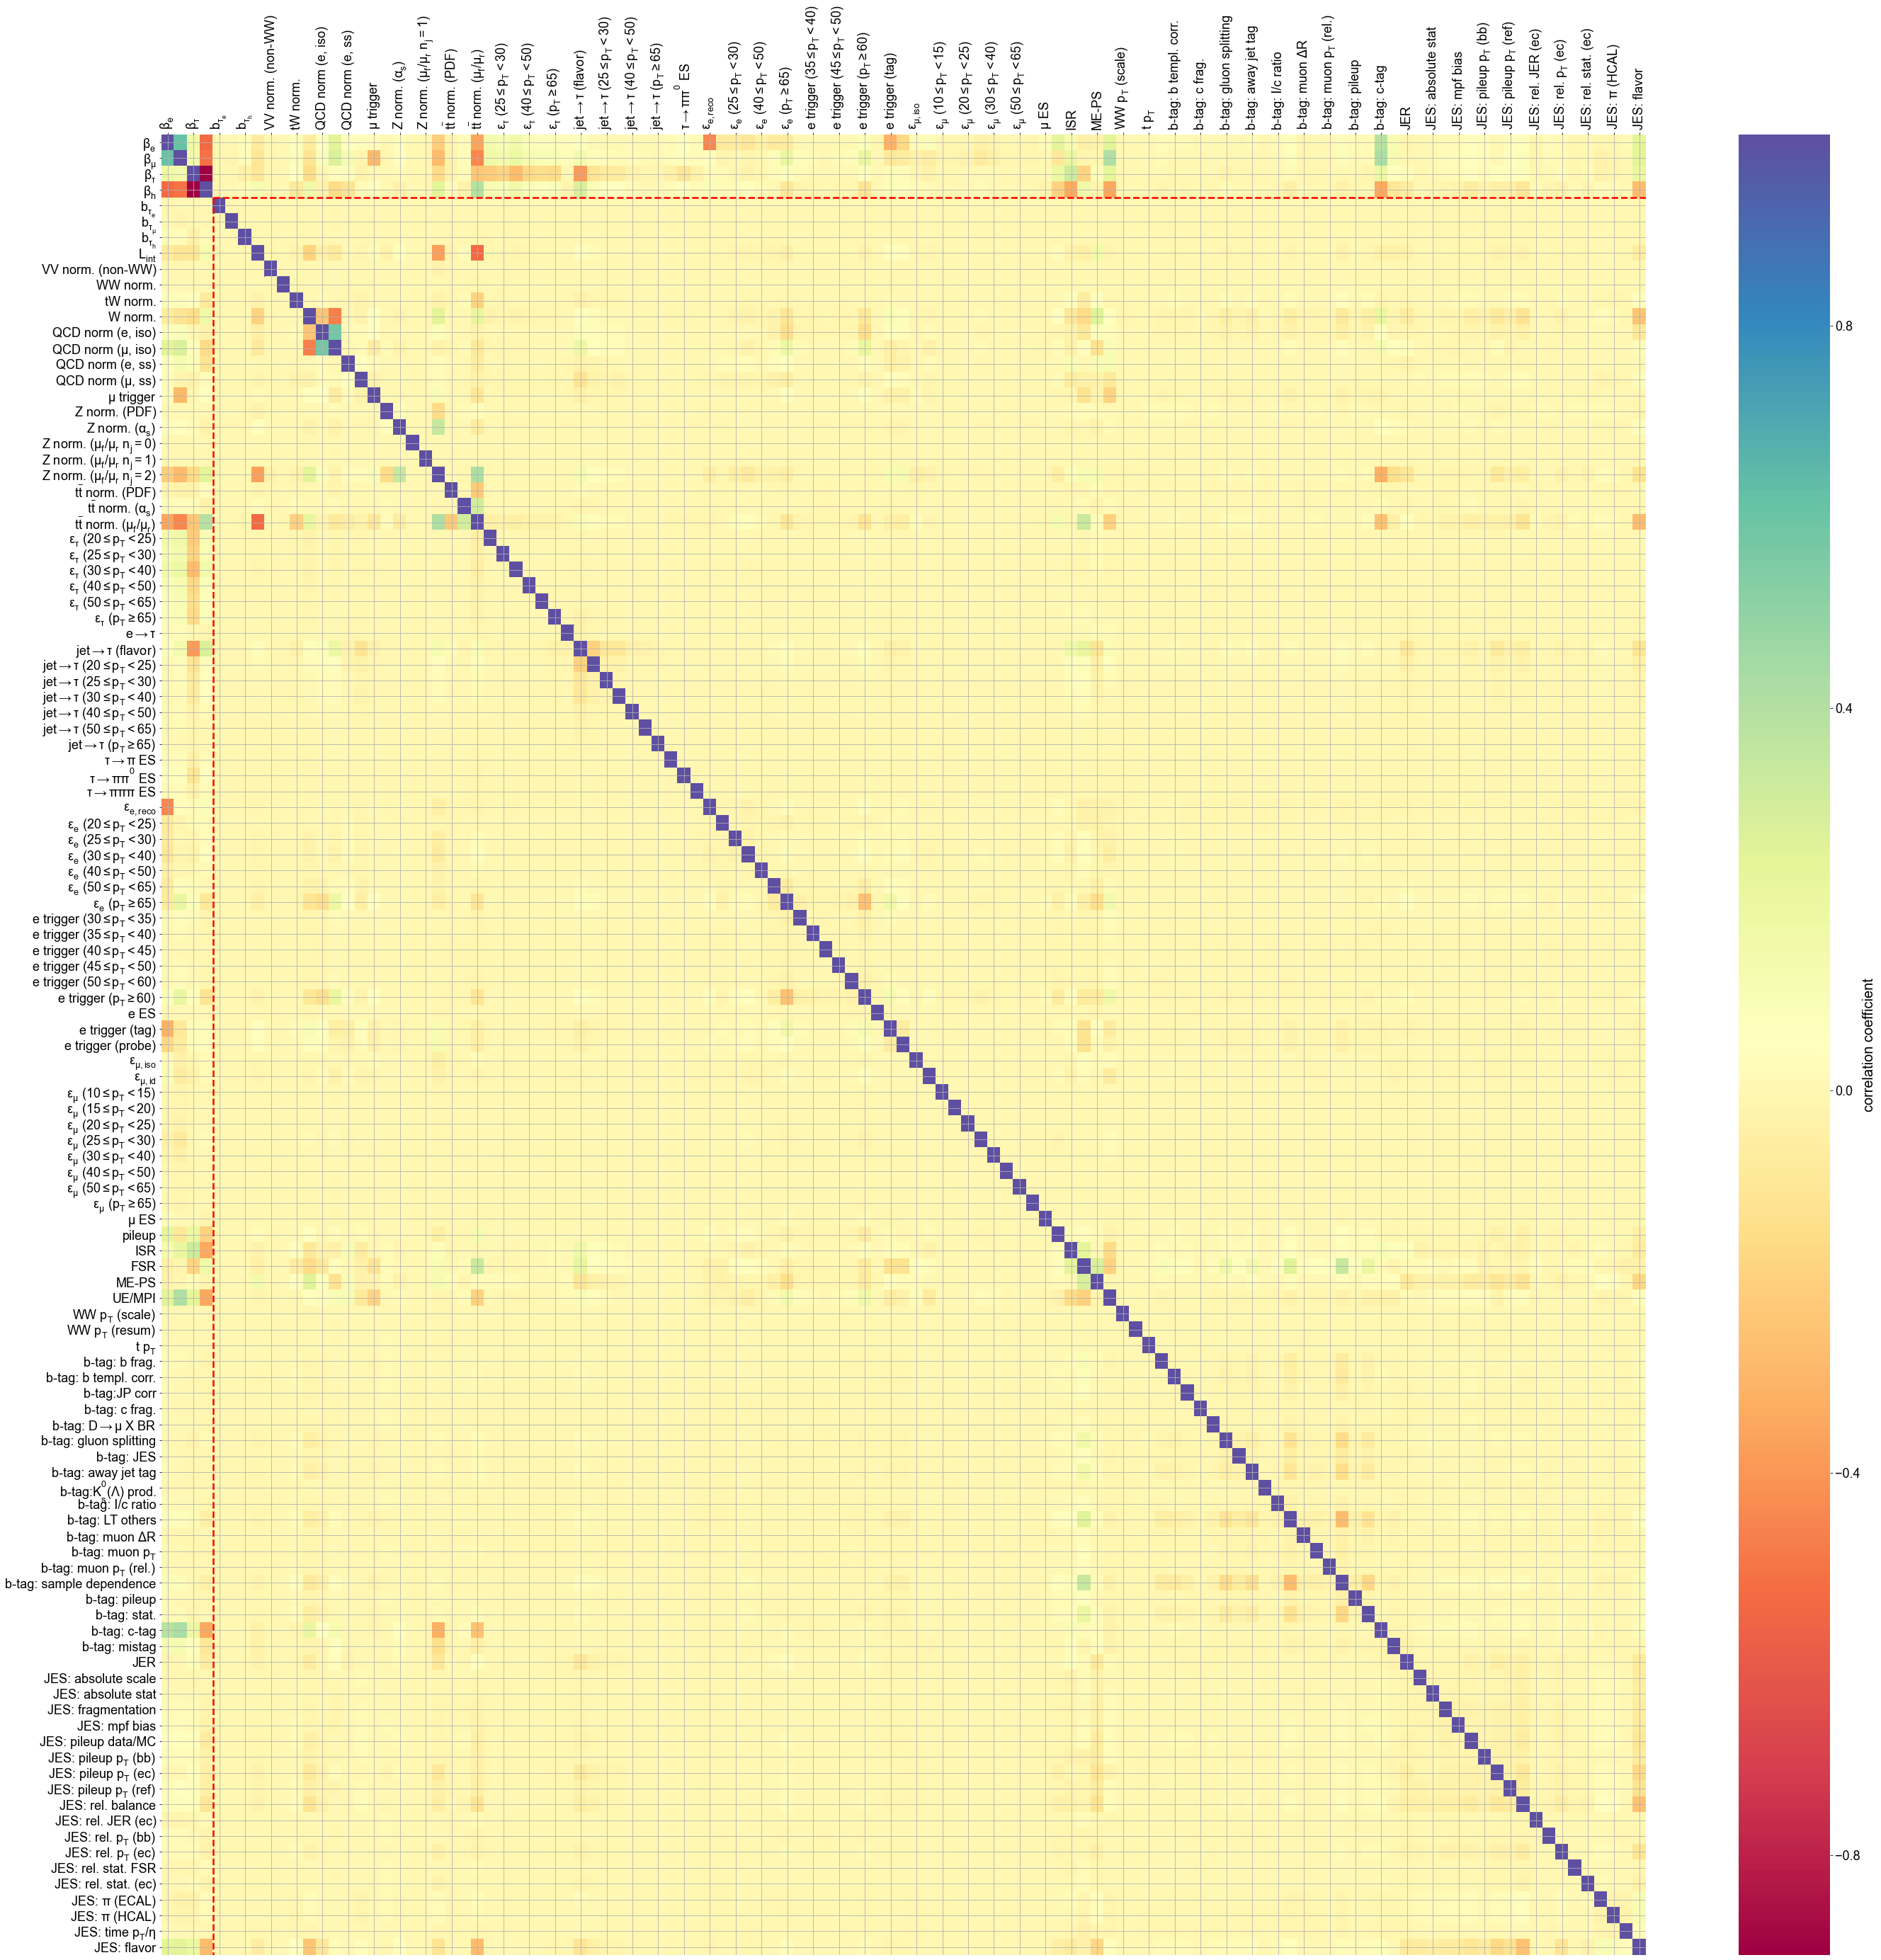

In [14]:
# produce correlation matrix
p_labels = list(parameters.index)
p_labels_fancy = fit_data._parameters.label[mask]

df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.iloc[4:,4:].to_latex(f'local_data/corr_table_full_{scenario}.tex')
df_corr.iloc[4:,4:].to_csv(f'local_data/corr_table_full_{scenario}.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(40, 40))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
ax.grid()
#ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/systematics/correlation_matrix_{scenario}.pdf')
plt.show()